In [1]:
##코랩실행시 google driver mount 하기
#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS


# 3D_Dilated CNN with meta
- Clahe
- Data Aug_abnormal case_Over Sampling

In [1]:
# Download packages
!pip install pydicom
!pip install imgaug
!pip install cv2
!pip install tensorflow
!pip install keras 
!pip install SimpleITK

  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached Shapely-1.7.1-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
     |████████████████████████████████| 26.0 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 454 kB 11.8 MB/s eta 0:00:01


  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Processing /home/niausr/.cache/pip/wheels/13/90/db/290ab3a34f2ef0b5a0f89235dc2d40fea83e77de84ed2dc05c/PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl


In [1]:
# Load Libraries
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob
import pydicom as pdc
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
#import tensorflow_hub as hub
from skimage import exposure
%pylab inline
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU') # gpus[번호바꿔서 사용 0-3번]
tf.debugging.set_log_device_placement(True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#path = './metadata/'
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
# Phase feature 는 제거
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [3]:
# 데이터 전처리 중간 점검
patient_meta

array([['SN00180816', 1, 0, 1, -0.9717086332456366],
       ['SN00361989', 1, 1, 0, -1.0655029028639413],
       ['SN00481545', 2, 1, 0, 0.9041767591204574],
       ['SN00493709', 2, 0, 1, 0.43520541102893384],
       ['SN00181638', 0, 0, 1, -0.31514874591750375],
       ['SN00222863', 0, 0, 1, 0.15382260217401975],
       ['SN00283964', 0, 0, 1, 0.997971028738762],
       ['SN00304545', 0, 1, 0, 0.9041767591204574],
       ['SN00450700', 2, 1, 0, 0.7165882198838479],
       ['SN00508749', 1, 0, 1, 0.997971028738762],
       ['SN00090078', 0, 1, 0, -0.03376593706258964],
       ['SN00369027', 0, 1, 0, -0.31514874591750375],
       ['SN00474278', 0, 1, 0, -1.44067998133716],
       ['SN00305004', 0, 1, 0, -1.3468857117188553],
       ['SN00508618', 0, 0, 1, 0.997971028738762],
       ['SN00067936', 0, 1, 0, -2.4724169471385116],
       ['SN00381399', 2, 0, 1, -0.6903258243907225],
       ['SN00407113', 1, 1, 0, 1.0917652983570667],
       ['SN00097002', 1, 0, 1, 1.3731481072119809],
   

In [4]:
label_df = pd.read_csv('../Diagnosis_Gallbladder_Cancer/metadata/label_df.csv')
#label_df = pd.read_csv('./metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


- Z축을 5만큼 잘라서 작업
- Clahe 전처리를 시켜주고, resize는 normalize 후 처리해준다 ( resize = (64,64) )

In [69]:
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64)
n_ct_statistics=[]
path = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/'
# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    for tr_idx in tr_list:
        X_i_tr_ct_list = sorted(glob.glob(path+patient_meta[tr_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
            # 전처리 --> normalize --> resize   
            ct_block.append(cv2.resize(cv2.normalize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            #ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
        ct_block = np.array(ct_block)
         # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[tr_idx, 0],'DX']
        dx_block = np.array(dx_block)
    
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1   # for 문 마지막 인덱스 설정
        X_i_tr_buffer = []
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size])   # 설정된 윈도우 사이즈 만큼 사진을 가져온다.
            X_p_tr.append(patient_meta[tr_idx, 0])            # 환자 번호
            X_m_tr.append(patient_meta[tr_idx, 2:])           # 환자 메타 정보 
            maxVal = np.max(dx_block[z:z+window_size])
            Y_tr.append(maxVal)                               # DX
            
            #Y_tr.append(patient_meta[tr_idx, 1])              
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        X_i_te_ct_list = sorted(glob.glob(path+patient_meta[te_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
                ct_block.append(cv2.resize(cv2.normalize((pdc.dcmread(X_i_te_ct_list[z])).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dsize=size))
        ct_block = np.array(ct_block)
        
        # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[te_idx, 0],'DX']
        dx_block = np.array(dx_block)
  
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size])
            X_p_te.append(patient_meta[te_idx, 0])
            X_m_te.append(patient_meta[te_idx, 2:])

            maxVal = np.max(dx_block[z:z+window_size])
            Y_te.append(maxVal)                               # DX
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    break

(11059,) (11059, 3) (11059, 5, 64, 64) (11059,)
(2348,) (2348, 3) (2348, 5, 64, 64) (2348,)


In [70]:
#print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)

In [71]:
# CT Length Statistics
np.mean(n_ct_statistics)

138.07

In [72]:
# Class Balance
#print(len(Y_tr[Y_tr==0]), len(Y_tr_abnormal[Y_tr_abnormal==1]), len(Y_tr_abnormal[Y_tr_abnormal==2]), len(Y_tr_abnormal[Y_tr_abnormal==3]))
#print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

In [73]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
np.save(path+'X_p_tr_final2', X_p_tr), np.save(path+'X_m_tr_final2', X_m_tr), np.save(path+'X_i_tr_final2', X_i_tr), np.save(path+'Y_tr_final2', Y_tr)
np.save(path+'X_p_te_final2', X_p_te), np.save(path+'X_m_te_final2', X_m_te), np.save(path+'X_i_te_final2', X_i_te), np.save(path+'Y_te_final2', Y_te)
#np.save(path+'X_p_tr_abnormal_final2', X_p_tr_abnormal), np.save(path+'X_m_tr_abnormal_final2', X_m_tr_abnormal), np.save(path+'X_i_tr_abnormal_final2', X_i_tr_abnormal), np.save(path+'Y_tr_abnormal_final2', Y_tr_abnormal)
#np.save(path+'np/X_p_te_abnormal_final2', X_p_te_abnormal), np.save(path+'np/X_m_te_abnormal_final2', X_m_te_abnormal), np.save(path+'np/X_i_te_abnormal_final2', X_i_te_abnormal), np.save(path+'np/Y_te_abnormal_final2', Y_te_abnormal)

(None, None, None, None)

In [74]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
#print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)

(11059,) (11059, 3) (11059, 5, 64, 64) (11059,)
(2348,) (2348, 3) (2348, 5, 64, 64) (2348,)


In [53]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final2.npy'), np.load(path+'X_m_tr_final2.npy', allow_pickle=True), np.load(path+'X_i_tr_final2.npy'), np.load(path+'Y_tr_final2.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final2.npy'), np.load(path+'X_m_te_final2.npy', allow_pickle=True), np.load(path+'X_i_te_final2.npy'), np.load(path+'Y_te_final2.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(10878,) (10878, 3) (10878, 5, 64, 64) (10878,) (10878, 4)
(2529,) (2529, 3) (2529, 5, 64, 64) (2529,) (2529, 4)


In [ ]:
## 여기서 부터

In [75]:
X_p = np.concatenate((X_p_tr, X_p_te), axis=0)
X_m = np.concatenate((X_m_tr, X_m_te), axis=0)
X_i = np.concatenate((X_i_tr, X_i_te), axis=0)
Y = np.concatenate((Y_tr, Y_te), axis=0)

from sklearn.model_selection import train_test_split

X_i_tr, X_i_te, Y_tr, Y_te = train_test_split(X_i,Y, test_size =0.3, random_state=42)
X_m_tr, X_m_te, Y_tr, Y_te = train_test_split(X_m,Y, test_size =0.3, random_state=42)
X_p_tr, X_p_te, Y_tr, Y_te = train_test_split(X_p,Y, test_size =0.3, random_state=42)

In [76]:
X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal ,Y_tr_abnormal = [], [], [], []
X_p_tr_normal, X_m_tr_normal, X_i_tr_normal ,Y_tr_normal = [], [], [], [] 
for i in range (len(X_p_tr)):
    if (Y_tr[i] == 0) :
        X_p_tr_normal.append(X_p_tr[i])
        X_m_tr_normal.append(X_m_tr[i])
        X_i_tr_normal.append(X_i_tr[i])
        Y_tr_normal.append(Y_tr[i])
    else:
        X_p_tr_abnormal.append(X_p_tr[i])
        X_m_tr_abnormal.append(X_m_tr[i])
        X_i_tr_abnormal.append(X_i_tr[i])
        Y_tr_abnormal.append(Y_tr[i])

X_p_tr, X_m_tr, X_i_tr, Y_tr = [],[],[],[]
X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal ,Y_tr_abnormal = np.array(X_p_tr_abnormal), np.array(X_m_tr_abnormal), np.array(X_i_tr_abnormal), np.array(Y_tr_abnormal)
#X_p_tr,X_m_tr, X_i_tr, Y_tr = np.array(X_m_tr), np.array(X_p_tr), np.array(X_i_tr), np.array(Y_tr)
X_p_tr, X_m_tr, X_i_tr, Y_tr =  np.array(X_p_tr_normal) , np.array(X_m_tr_normal) , np.array(X_i_tr_normal), np.array(Y_tr_normal)

In [77]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape)

(7536,) (7536, 3) (7536, 5, 64, 64) (7536,)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023,)
(1848,) (1848, 3) (1848, 5, 64, 64) (1848,)


In [57]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
np.save(path+'X_p_tr_final2', X_p_tr), np.save(path+'X_m_tr_final2', X_m_tr), np.save(path+'X_i_tr_final2', X_i_tr), np.save(path+'Y_tr_final2', Y_tr)
np.save(path+'X_p_te_final2', X_p_te), np.save(path+'X_m_te_final2', X_m_te), np.save(path+'X_i_te_final2', X_i_te), np.save(path+'Y_te_final2', Y_te)
np.save(path+'X_p_tr_abnormal_final2', X_p_tr_abnormal), np.save(path+'X_m_tr_abnormal_final2', X_m_tr_abnormal), np.save(path+'X_i_tr_abnormal_final2', X_i_tr_abnormal), np.save(path+'Y_tr_abnormal_final2', Y_tr_abnormal)
#np.save(path+'np/X_p_te_abnormal_final2', X_p_te_abnormal), np.save(path+'np/X_m_te_abnormal_final2', X_m_te_abnormal), np.save(path+'np/X_i_te_abnormal_final2', X_i_te_abnormal), np.save(path+'np/Y_te_abnormal_final2', Y_te_abnormal)

(None, None, None, None)

### Augmentation 작업 전

In [58]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final2.npy'), np.load(path+'X_m_tr_final2.npy', allow_pickle=True), np.load(path+'X_i_tr_final2.npy'), np.load(path+'Y_tr_final2.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final2.npy'), np.load(path+'X_m_te_final2.npy', allow_pickle=True), np.load(path+'X_i_te_final2.npy'), np.load(path+'Y_te_final2.npy')
X_p_tr_abnormal, X_m_tr_abnormal, X_i_tr_abnormal, Y_tr_abnormal = np.load(path+'X_p_tr_abnormal_final2.npy'), np.load(path+'X_m_tr_abnormal_final2.npy', allow_pickle=True), np.load(path+'X_i_tr_abnormal_final2.npy'), np.load(path+'Y_tr_abnormal_final2.npy')

X_m_tr, X_m_te, X_m_tr_abnormal = X_m_tr.astype('float32'), X_m_te.astype('float32'), X_m_tr_abnormal.astype('float32')
Y_tr_cat, Y_te_cat, Y_tr_abnormal_cat  = to_categorical(Y_tr), to_categorical(Y_te), to_categorical(Y_tr_abnormal) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)
print(X_p_tr_abnormal.shape, X_m_tr_abnormal.shape, X_i_tr_abnormal.shape, Y_tr_abnormal.shape, Y_tr_abnormal_cat.shape)

(7551,) (7551, 3) (7551, 5, 64, 64) (7551,) (7551, 1)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023,) (4023, 4)
(1833,) (1833, 3) (1833, 5, 64, 64) (1833,) (1833, 4)


### Augmentation 작업 후

In [78]:
# Augmentations
import imgaug as ia
import imgaug.augmenters as iaa
window_size = 5
n_aug = 2
path = './np/'
#path = './benchmark_liver_tumor/raw/np/'
for a in range(n_aug):
    seq_pipeline = iaa.Sequential([
        iaa.Sometimes(0.5, iaa.Fliplr(0.5)),   # horizontally flip 50% of all image 
        iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))), # 0-10% 비율로 높이와 너비를 잘라준다.
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.Sometimes(0.5, iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},   # x,y축 모두 80-120% 크기변환
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # x,y 축모두 -20 에서 +20으로 축변환
            rotate=(-25, 25),  # -25 에서 25 도 각도 변화
            shear=(-8, 8))), # -16에서 16 기울기 변화
        iaa.Sometimes(0.5, iaa.LinearContrast((0.75, 1.5))) # 이미지의 대조를 악화시키거나 개선 시킨다.
        ## 추가해 볼 기법들
        # mixup
    ], random_order=True)
    X_i_tr_abnormal_aug = np.copy(X_i_tr_abnormal)
    for r in range(X_i_tr_abnormal_aug.shape[0]):
        buffer_block = X_i_tr_abnormal_aug[r]
        for z in range(window_size):
            buffer_block[z] = seq_pipeline(images=buffer_block[z])
        X_i_tr_abnormal_aug[r] = buffer_block
    X_p_tr_abnormal_aug, X_m_tr_abnormal_aug, Y_tr_abnormal_aug = np.copy(X_p_tr_abnormal), np.copy(X_m_tr_abnormal), np.copy(Y_tr_abnormal)
    np.save(path+'X_p_tr_abnormal_aug_%02d' %(a), X_p_tr_abnormal_aug), np.save(path+'X_m_tr_abnormal_aug_%02d' %(a), X_m_tr_abnormal_aug), np.save(path+'X_i_tr_abnormal_aug_%02d' %(a), X_i_tr_abnormal_aug), np.save(path+'Y_tr_abnormal_aug_%02d' %(a), Y_tr_abnormal_aug)

In [79]:
# Load Augmented Dataset and concat with original train Dataset
#path = './benchmark_liver_tumor/raw/np/'
path = './np/'
n_aug = 2
for a in range(n_aug):
    X_p_buffer, X_m_buffer, X_i_buffer, Y_tr_buffer = np.load(path+'X_p_tr_abnormal_aug_%02d.npy' %(a)), np.load(path+'X_m_tr_abnormal_aug_%02d.npy' %(a), allow_pickle=True).astype('float32'), np.load(path+'X_i_tr_abnormal_aug_%02d.npy' %(a)), np.load(path+'Y_tr_abnormal_aug_%02d.npy' %(a))
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.concatenate((X_p_tr, X_p_buffer), axis=0), np.concatenate((X_m_tr, X_m_buffer), axis=0), np.concatenate((X_i_tr, X_i_buffer), axis=0), np.concatenate((Y_tr, Y_tr_buffer), axis=0)
Y_tr_cat = to_categorical(Y_tr)
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(11232,) (11232, 3) (11232, 5, 64, 64) (11232,) (11232, 4)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023,) (4023, 4)


### Save augmented Dataset 
- 여기서 부터 실행

In [80]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/np_3d_oversample/'
path = './np_aug_2_oversampling/'
np.save(path+'X_p_tr_final22', X_p_tr), np.save(path+'X_m_tr_final22', X_m_tr), np.save(path+'X_i_tr_final22', X_i_tr), np.save(path+'Y_tr_final22', Y_tr)
np.save(path+'X_p_te_final22', X_p_te), np.save(path+'X_m_te_final22', X_m_te), np.save(path+'X_i_te_final22', X_i_te), np.save(path+'Y_te_final22', Y_te)

(None, None, None, None)

### Load final Dataset

In [2]:
# Load Dataset
#path = './benchmark_liver_tumor/raw/np_3d_oversample/'
path = './np_aug_2_oversampling/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final22.npy'), np.load(path+'X_m_tr_final22.npy', allow_pickle=True), np.load(path+'X_i_tr_final22.npy'), np.load(path+'Y_tr_final22.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final22.npy'), np.load(path+'X_m_te_final22.npy', allow_pickle=True), np.load(path+'X_i_te_final22.npy'), np.load(path+'Y_te_final22.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(11232,) (11232, 3) (11232, 5, 64, 64) (11232,) (11232, 4)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023,) (4023, 4)


In [3]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

7536 1938 1150 608
3267 402 230 124


In [4]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
X_i_tr_abnormal = np.rollaxis(X_i_tr_abnormal, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)
print(X_i_tr_abnormal.shape)

NameError: name 'X_i_tr_abnormal' is not defined

In [5]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)

'''
# Build Meta-data
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()
'''


#cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

#display(Image(filename="./Kyoung/Image/cnn.png"))

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [6]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/200

Epoch 5/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
375/375 - 5s - loss: 0.2430 - accuracy: 0.8953 - val_loss: 1.7302 - val_accuracy: 0.8121
Epoch 6/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0

375/375 - 5s - loss: 0.0685 - accuracy: 0.9751 - val_loss: 1.9234 - val_accuracy: 0.8121
Epoch 14/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
375/375 - 5s - loss: 0.0616 - accuracy: 0.9773 - val_loss: 1.3603 - val_accura

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
375/375 - 5s - loss: 0.0118 - accuracy: 0.9968 - val_loss: 1.8706 - val_accuracy: 0.8131
Epoch 23/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
375/375 - 5s - loss: 4.3103e-04 - accuracy: 1.0000 - val_loss: 2.0819 - val_accuracy: 0.8121
Epoch 32/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/

In [86]:
cnn.evaluate(X_i_te,Y_te_cat)

126/126 [==============================] - 1s 5ms/step - loss: 2.2618 - accuracy: 0.8121


[2.261842727661133, 0.8120805621147156]

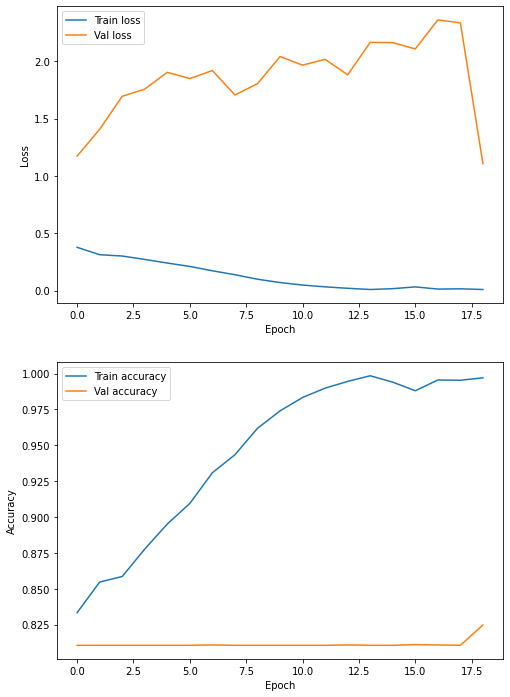

In [25]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩 

In [8]:
# save model
cnn_meta.save("./models/Dilated_3D_cnn_meta_aug_oversampling.h5")

# model load하는 경우
cnn_meta  = tf.keras.models.load_model("./models/Dilated_3D_cnn_meta_aug_oversampling.h5")

## Confusion Matrix
- X train을 통한 메트릭스
- X test를 통한 메트릭스

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [28]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'non-ROI'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

In [29]:
# X_train을 통한 예측값 비교
y_pred = cnn.predict(X_i_tr)
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[1132    0    0    0]
 [   2  589    1    0]
 [   9    0 1951    0]
 [   0    0    0 7542]]
                    precision    recall  f1-score   support

               HCC       0.99      1.00      1.00      1132
cholangiocarcinoma       1.00      0.99      1.00       592
        metastasis       1.00      1.00      1.00      1960
           non-ROI       1.00      1.00      1.00      7542

          accuracy                           1.00     11226
         macro avg       1.00      1.00      1.00     11226
      weighted avg       1.00      1.00      1.00     11226



In [30]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn.predict(X_i_te)    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

#from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[   0    0    0  239]
 [   0    0    0  132]
 [   0    0    0  391]
 [   0    0    0 3261]]
                    precision    recall  f1-score   support

               HCC       0.00      0.00      0.00       239
cholangiocarcinoma       0.00      0.00      0.00       132
        metastasis       0.00      0.00      0.00       391
           non-ROI       0.81      1.00      0.90      3261

          accuracy                           0.81      4023
         macro avg       0.20      0.25      0.22      4023
      weighted avg       0.66      0.81      0.73      4023



/home/super/anaconda3/envs/Kyoung/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CAM

In [96]:
print(cnn.predict(X_i_te)[0])

[9.9999857e-01 1.2015669e-06 2.9178506e-07 3.9201371e-09]


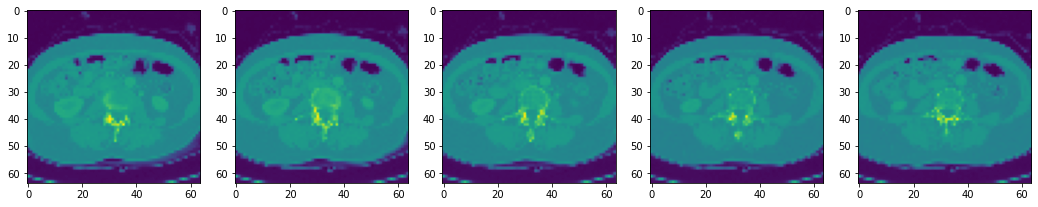

In [94]:
f, ax = plt.subplots(1,5,figsize=(18,8)) 

for i in range(5): 
    X_i_tr[0][:,:,i].shape
    img = X_i_tr[0][:,:,i]
    img = np.expand_dims(img, axis=2)
    #img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # 2차원 배열을 3차원으로 3번 복사 
    img.shape
    
    ax[i].imshow(img)

In [232]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 5), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.
    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad
    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer], to_padding, **kwargs)

In [233]:
##----Load---Image
import SimpleITK as sitk
#img_path='../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/SN00017916/SN00017916_0021.dcm'
#img_sitk = sitk.ReadImage(img_path, sitk.sitkFloat32)
img_stik = X_i_tr[0]
image= sitk.GetArrayFromImage(img_sitk)
resized_img=resize_image_with_crop_or_pad(image=image,img_size=(64,64,5),mode='symmetric')
#resized_img=image
resized_img.shape
io_img=tf.expand_dims(resized_img, axis=-1)
print(io_img.shape)
io_img=tf.expand_dims(io_img, axis=0)
print(io_img.shape)
###----index of the class
CLASS_INDEX=2

model = cnn
LAYER_NAME = 'conv2d_19'
# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

###--Compute GRADIENT
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(io_img)
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

(64, 64, 5, 1)
(1, 64, 64, 5, 1)


<ipython-input-232-ce178b320778>:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad(image[slicer], to_padding, **kwargs)


In [227]:
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
    
#cam.shape, weights.shape, output[:, :, :, 0].shape

Text(0.5, 1.0, 'Overlay')

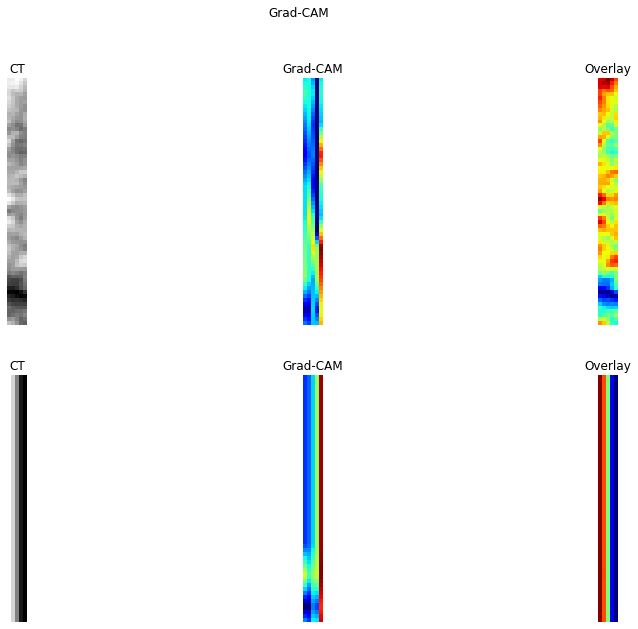

In [238]:
from skimage.transform import resize
from matplotlib import pyplot as plt
capi=resize(cam,(64,64,5))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')
slice_count=63
slice_count2=63
    
axial_ct_img=np.squeeze(resized_img[slice_count, :,:])
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])

coronal_ct_img=np.squeeze(resized_img[:,slice_count2,:])
coronal_grad_cmap_img=np.squeeze(heatmap[:,slice_count2,:]) 

img_plot = axarr[0,0].imshow(resized_img[slice_count, :,:], cmap='gray');
#img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')
    
img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Grad-CAM')
    
axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[0,2].imshow(axial_overlay,cmap='jet');
axarr[0,2].axis('off')
axarr[0,2].set_title('Overlay')


img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')
    
Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)
    
img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')
axarr[1,2].set_title('Overlay')